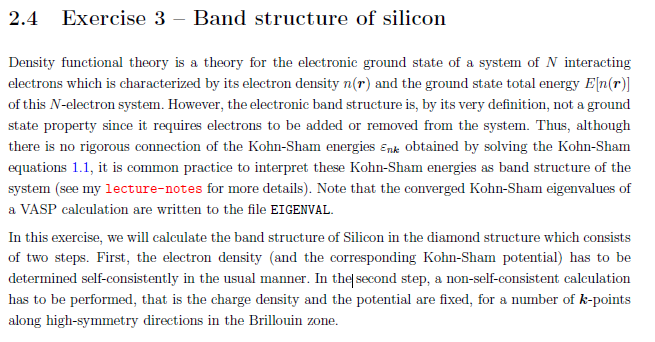

In [1]:
# Import necessary modules
import numpy as np
from ase.build import bulk
from ase.visualize import view
from ase.dft.kpoints import ibz_points, bandpath
from gpaw import GPAW, PW
import matplotlib.pyplot as plt




### First, the electron density (and the corresponding Kohn-Sham potential)

In [2]:
si = bulk('Si', 'diamond', a=5.43) # a traken from poscar file


calc = GPAW(mode=PW(240), # taken from INCAR file 
            xc='PBE',    
            kpts=(12, 12, 12),# Monkhurs is default from KPOINTS file
            txt='si_gs.txt') 


si.calc = calc

# Perform the ground-state calculation
si.get_potential_energy()


-10.786955013518098

### Second, calculation along high-symmetry directions in the Brillouin zone

a non-self-consistent calculation has to be performed, that is the charge density and the potential are fixed, for a number of k-points <br>

Use a denser 𝑘-point mesh along high-symmetry paths in the Brillouin zone to accurately sample the electronic band structure.<br>
The NSCF calculation involves solving the Kohn-Sham equations without updating the charge density or potential, effectively using the fixed charge density and potential from the "normal" DFT.<br>

Performing a full SCF calculation on a very dense 𝑘-point mesh is computationally expensive and often unnecessary. By fixing the charge density and potential, the NSCF calculation focuses on accurately determining the electronic eigenvalues, making the process more efficient.


In [ ]:
# efine high-symmetry points for the band structure calculation
points = ibz_points['fcc'] 
W = points['W']
G = points['Gamma']
X = points['X']
L = points['L']
K = points['K']

# Define the band path
path = [W, L, G, X, W, K]
npoints = 80  # Number of points along each segment
band_path = bandpath(path, si.cell, npoints=npoints)


# Save the ground state calculation
calc.write('si_gs.gpw')

#  Set up a separate calculation for the band structure
calc = GPAW('si_gs.gpw',  # Restart from the ground state calculation
            kpts={'path': band_path.kpts, 'npoints': npoints},  # Define k-point path
            fixdensity=True,  # Use the density from the ground state
            symmetry='off',  # Turn off symmetry to avoid issues
            convergence={'bands': 8},  # maximum number of bands
            txt='si_band.txt')
  
# Perform the band structure caclculation and show results
calc.get_potential_energy()
bs = calc.band_structure()

### Plot the result

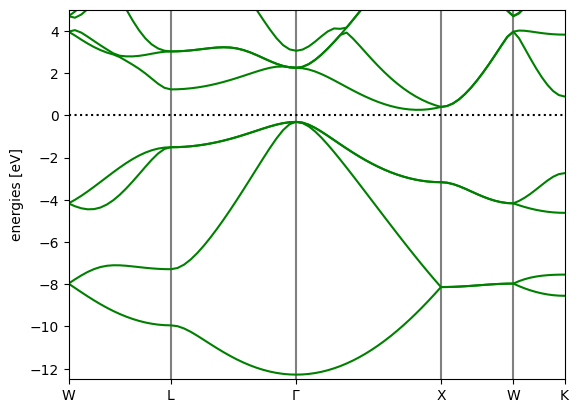

In [31]:
ef = calc.get_fermi_level()
bs = bs.subtract_reference() #  the same as substracting fermi level
bs.plot(filename='si_band_structure.png',emin=-12.5,emax=5)
#plt.ylim((-8,10))
plt.show()

# Questions

### How many occupied bands are there? Why?

4 Bands all below the fermi level [dotted line in plot]


### Why do certain directions (e.g. X −W) appear to have less bands than other directions (e.g. W −L)?

I would guess that either the energy is degenerate. In some directions, bands may be closely spaced or degenerate. In other directions, these bands may split due to interactions such as spin-orbit coupling or crystal field effects.

another possibility could be:

Some kind of symmetrie of the crystalline structure.


### How large is the computed Kohn-Sham band gap?


reference from script of Fundamentals of Electronic Structure Theory [Prof. Puschnig]

"Experience shows that \Delta xc is a substantial part of the band gap. As a result the Kohn-Sham band gap calculated with approximate functionals such as the LDA or the GGA amounts to only about 50% of the true band gap."

experimental result: 1.17 eV
computational result: 0.57 eV


Bandgap: 0.5712746079580384 eV


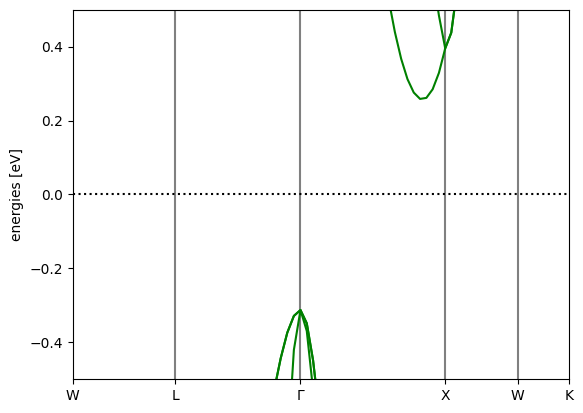

In [36]:
# calculating the band gap: 
#fermi = calc.get_fermi_level()
fermi = 0

band_energies = bs.energies


cond_e = np.min(band_energies[band_energies > fermi])
val_e = np.max(band_energies[band_energies <= fermi])

bandgap = cond_e - val_e

print(f"Bandgap: {bandgap} eV")

bs.plot(filename='si_band_structure.png',emin=-0.5,emax=0.5)
plt.show()